In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from cvxopt import matrix, solvers

In [5]:
def get_asset_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)['Close']
    return data

# list of assets
tickers = ['AAPL', 'TXNM', 'MSFT', 'JNJ', 'CL', 'NVDA']
start_date = '2020-01-01'
end_date = '2025-01-01'

data = get_asset_data(tickers, start_date, end_date)
data.head()

[*********************100%***********************]  6 of 6 completed


Ticker,AAPL,CL,JNJ,MSFT,NVDA,TXNM
Date,,,,,,
2020-01-02,72.796021,60.578106,127.064194,153.630692,5.972711,42.580250
2020-01-03,72.088303,60.489162,125.593079,151.717697,5.877111,42.725918
2020-01-06,72.662712,60.907124,125.436424,152.109894,5.901758,42.631672
2020-01-07,72.320976,60.071205,126.202385,150.722961,5.973209,42.160362
2020-01-08,73.484352,61.600769,126.184998,153.123764,5.984412,41.980412


Ticker
AAPL    0
CL      0
JNJ     0
MSFT    0
NVDA    0
TXNM    0
dtype: int64


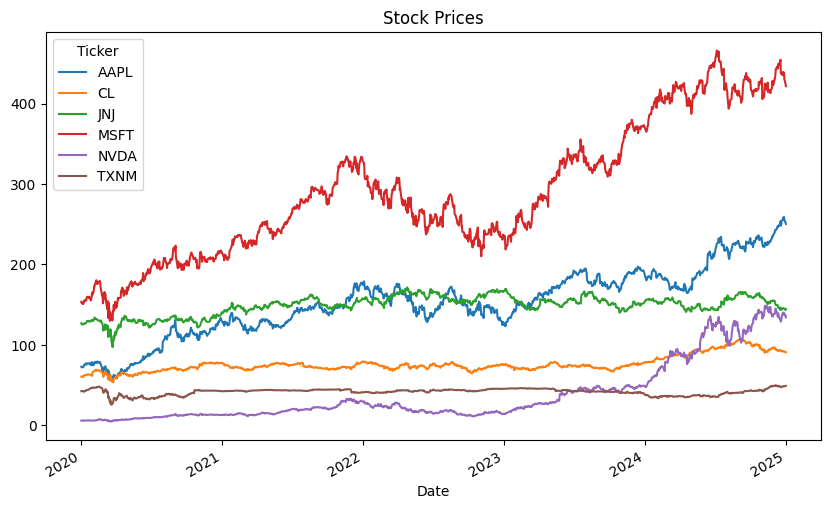

In [6]:
# Minimal Preprocessing
print(data.isna().sum())

# Visualize
data.plot(figsize=(10,6))
plt.title("Stock Prices")
plt.show()

In [7]:
# daily returns
returns = data.pct_change().dropna()

# Annualize the expected returns - 252 trading days in a year
expected_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

print("Expected Annual Returns:\n", expected_returns)
print("\nAnnualized Covariance Matrix:\n", cov_matrix)

Expected Annual Returns:
 Ticker
AAPL    0.297892
CL      0.102727
JNJ     0.045193
MSFT    0.248931
NVDA    0.768566
TXNM    0.061923
dtype: float64

Annualized Covariance Matrix:
 Ticker      AAPL        CL       JNJ      MSFT      NVDA      TXNM
Ticker                                                            
AAPL    0.100354  0.024000  0.023303  0.072297  0.103501  0.029829
CL      0.024000  0.042810  0.023097  0.025604  0.020429  0.024973
JNJ     0.023303  0.023097  0.038638  0.022720  0.015698  0.019271
MSFT    0.072297  0.025604  0.022720  0.093008  0.112086  0.029264
NVDA    0.103501  0.020429  0.015698  0.112086  0.290293  0.033505
TXNM    0.029829  0.024973  0.019271  0.029264  0.033505  0.064715


In [8]:
def markowitz_optimization(expected_returns, cov_matrix, target_return):
    n = len(expected_returns)

    # Convert inputs to cvxopt matrices
    P = matrix(cov_matrix.values)
    q = matrix(np.zeros((n, 1)))

    # Inequality constraints Gx <= h
    G = matrix(-np.identity(n))
    h = matrix(np.zeros((n, 1)))

    # Equality constraints Ax = b
    # A: Expected returns and sum of weights
    A = matrix(np.vstack((expected_returns.values, np.ones(n))))
    b = matrix([target_return, 1.0])

    # quadratic programming problem
    sol = solvers.qp(P, q, G, h, A, b)

    if sol['status'] != 'optimal':
        print("Optimization failed with status:", sol['status'])
        return None

    # Extract optimal weights
    weights = np.array(sol['x']).flatten()
    return weights

In [9]:
def monte_carlo_simulation(expected_returns, cov_matrix, num_portfolios=50000):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    n_assets = len(expected_returns)

    for i in range(num_portfolios):
        # Generate random weights that sum to 1
        weights = np.random.rand(n_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)

        # Calculate portfolio return and risk
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        # Sharpe Ratio (Assuming risk-free rate is zero)
        sharpe_ratio = portfolio_return / portfolio_risk

        # Store the results
        results[0, i] = portfolio_return
        results[1, i] = portfolio_risk
        results[2, i] = sharpe_ratio

    return results, weights_record

# Run the Monte Carlo simulation
simulation_results, weights_record = monte_carlo_simulation(expected_returns, cov_matrix)

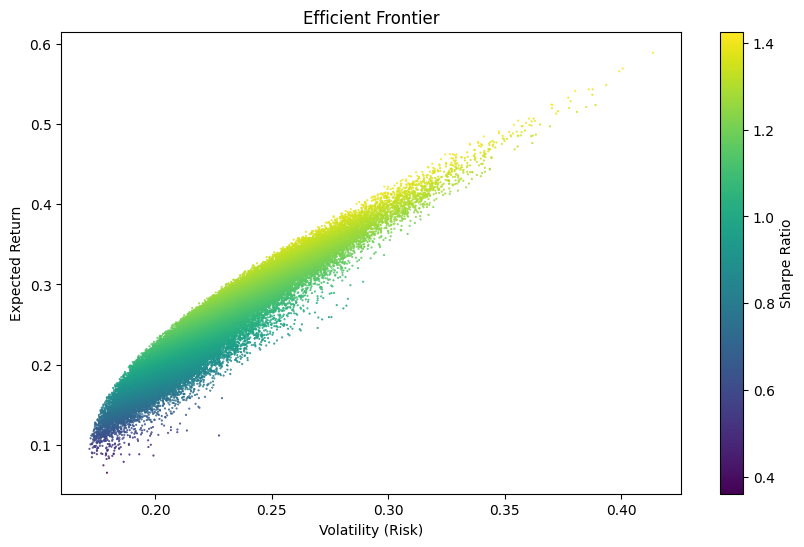

In [10]:
def plot_efficient_frontier(results):
    plt.figure(figsize=(10, 6))
    plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='.', s=1)
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Expected Return')
    plt.title('Efficient Frontier')
    plt.show()

plot_efficient_frontier(simulation_results)

In [11]:
def calculate_var(returns, weights, confidence_level=0.95):
    # Calculate portfolio returns
    portfolio_returns = returns.dot(weights)

    # Calculate the VaR at the specified confidence level
    var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    return var

In [12]:
def define_scenarios():
    return {
        'Downturn': -0.10,
        'Neutral': 0.00,
        'Boom': 0.10
    }

# Apply scenarios to the asset returns
def apply_scenarios(returns, scenarios):
    scenario_impact = {}

    for scenario, impact in scenarios.items():
        # Adjust returns based on the scenario
        adjusted_returns = returns + impact
        scenario_impact[scenario] = adjusted_returns.mean() * 252  # Annualize adjusted returns

    return scenario_impact

# Analyze the impact of each scenario on the portfolio
def analyze_scenarios(scenarios, optimal_weights, returns):
    scenario_impact = apply_scenarios(returns, scenarios)

    for scenario, adjusted_return in scenario_impact.items():
        # Calculate portfolio metrics under each scenario
        portfolio_return = np.dot(optimal_weights, adjusted_return)
        portfolio_risk = np.sqrt(np.dot(optimal_weights.T, np.dot(returns.cov() * 252, optimal_weights)))

        print(f"\nScenario: {scenario}")
        print(f"Adjusted Expected Return: {portfolio_return:.2%}")
        print(f"Portfolio Risk (Volatility): {portfolio_risk:.2%}")

# Define scenarios
scenarios = define_scenarios()

# Example: Optimize the portfolio for a target return of 15%
target_return = 0.15
optimal_weights = markowitz_optimization(expected_returns, cov_matrix, target_return)

if optimal_weights is not None:
    analyze_scenarios(scenarios, optimal_weights, returns)

     pcost       dcost       gap    pres   dres
 0:  1.7557e-02 -1.0173e+00  1e+00  5e-17  3e+00
 1:  1.7520e-02 -4.5848e-03  2e-02  7e-17  6e-02
 2:  1.6407e-02  1.3348e-02  3e-03  2e-16  5e-03
 3:  1.5755e-02  1.5340e-02  4e-04  2e-16  2e-17
 4:  1.5668e-02  1.5639e-02  3e-05  2e-16  1e-17
 5:  1.5653e-02  1.5652e-02  2e-06  1e-16  1e-17
 6:  1.5652e-02  1.5652e-02  2e-08  2e-16  2e-17
Optimal solution found.

Scenario: Downturn
Adjusted Expected Return: -2505.00%
Portfolio Risk (Volatility): 17.69%

Scenario: Neutral
Adjusted Expected Return: 15.00%
Portfolio Risk (Volatility): 17.69%

Scenario: Boom
Adjusted Expected Return: 2535.00%
Portfolio Risk (Volatility): 17.69%


In [13]:
# Adjust the tau value to reduce the effect of views
tau = 0.025  # Smaller tau can help reduce extreme adjustments

def black_litterman_model(expected_market_returns, cov_matrix, P, Q, tau=0.025):
    """
    :param expected_market_returns: Market equilibrium returns (CAPM-like)
    :param cov_matrix: Covariance matrix of the assets
    :param P: Pick matrix for views (shape k x n)
    :param Q: Views on the performance of the assets (shape k x 1)
    :param tau: Scalar reflecting uncertainty in the prior estimate of expected returns
    """
    # Scale the covariance matrix by tau
    scaled_cov_matrix = tau * cov_matrix

    # Compute the uncertainty in views (omega)
    omega = np.dot(np.dot(P, scaled_cov_matrix), P.T)

    # Compute Black-Litterman adjusted expected returns
    inv_term = np.linalg.inv(scaled_cov_matrix + np.dot(np.dot(P.T, np.linalg.inv(omega)), P))
    bl_returns = np.dot(inv_term, (np.dot(tau, np.dot(np.linalg.inv(cov_matrix), expected_market_returns)) +
                                   np.dot(np.dot(P.T, np.linalg.inv(omega)), Q)))

    return bl_returns

# Adjusted views: Keep them small and reasonable
P = np.array([[1, 0, 0, 0, 0, 0],   # View 1: AAPL
              [0, 0, 1, 0, 0, 0]])  # View 2: MSFT
Q = np.array([0.02, 0.01])  # 2% for AAPL, 1% for MSFT

# Market equilibrium returns based on historical data
market_returns = data.pct_change().mean()

# Estimate the covariance matrix of returns
cov_matrix = data.pct_change().cov()

# Compute Black-Litterman adjusted returns
bl_returns = black_litterman_model(market_returns.values, cov_matrix.values, P, Q, tau)

# Format the returns as a pandas Series
bl_returns_series = pd.Series(bl_returns, index=data.columns)
print("Black-Litterman Adjusted Expected Returns:\n", bl_returns_series)

Black-Litterman Adjusted Expected Returns:
 Ticker
AAPL        0.020000
CL      28690.308006
JNJ         0.010000
MSFT   -23715.149490
NVDA    10871.801078
TXNM    -9790.794186
dtype: float64
